In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [202]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12

sns.set_palette("colorblind")

In [203]:
import pandas_datareader.data as web

In [204]:
df = web.DataReader('^DJI', 'stooq')

In [205]:
returns = df["Close"].sort_index().pct_change()

In [221]:
import numpy as np
from numba import njit

@njit
def imq(err, c):
    return 1 / np.sqrt(1 + err ** 2 / c)

@njit
def wolf_step(y, m, s, q, r, c):
    # weight function and rate
    wt = imq(y - m, c) ** 2
    k = (s + q) / (s + q + r / wt ** 2)
    # posterior mean and variance
    m = k * y + (1 - k) * m
    s = k * r
    return (m, s), k

@njit
def wolf1d(y, m0, s0, q, r, c):
    m = m0
    s = s0
    m_hist = np.zeros_like(y)
    s_hist = np.zeros_like(y)
    k_hist = np.zeros_like(y)
    for t, yt in enumerate(y):
        (m, s), k = wolf_step(yt, m, s, q, r, c)
        m_hist[t] = m
        s_hist[t] = s
        k_hist[t] = k
    return m_hist, s_hist, k_hist

In [222]:
returns.iloc[1000] = 0.5
returns.iloc[500] = -0.5

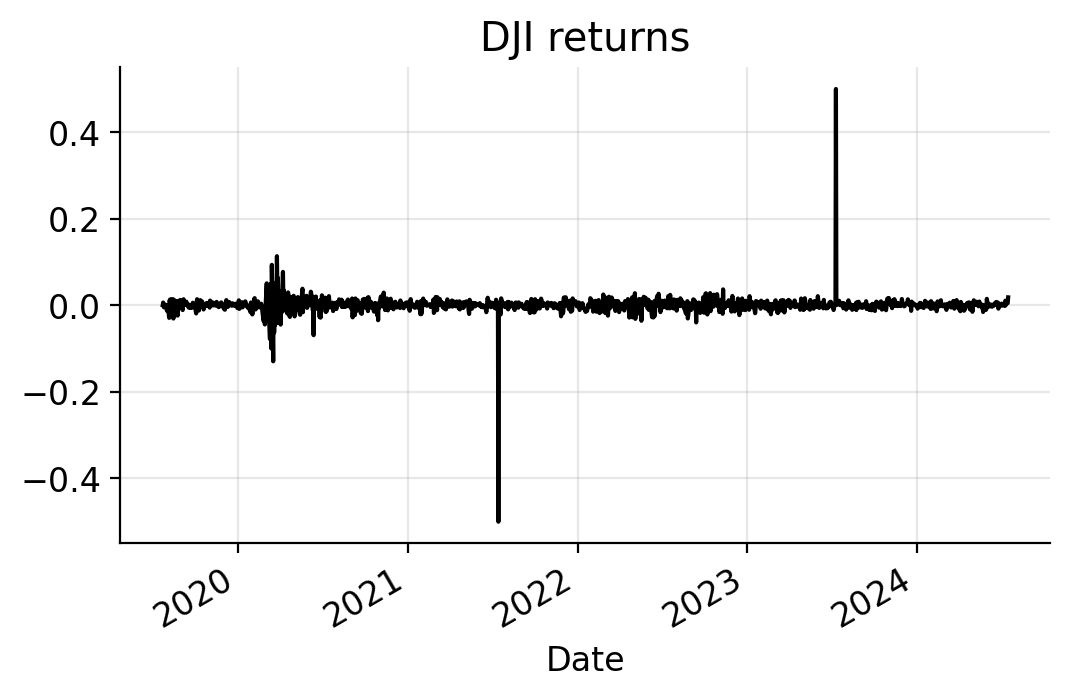

In [224]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.title("DJI returns")
returns.plot(c="black")
plt.grid(alpha=0.3)
plt.savefig("dji-returns.svg")

In [230]:
m_hist, s_hist, k_hist = wolf1d(returns.bfill().values, m0=0, s0=1, q=0.01, r=1.0, c=0.05)
k_hist = pd.Series(k_hist, index=returns.index)

In [231]:
m_hist = pd.Series(m_hist, returns.index)

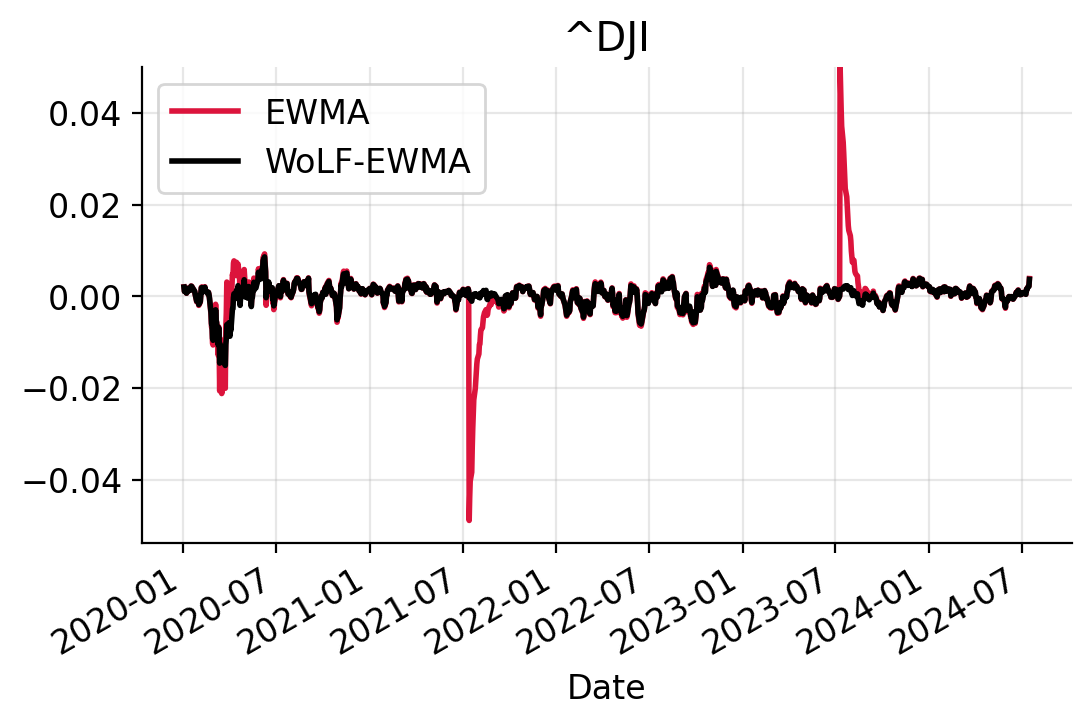

In [237]:
fig, ax = plt.subplots(figsize=(6, 3.5))
returns.ewm(alpha=0.1, adjust=False).mean()["2020":].plot(label="EWMA", c="crimson", linewidth=2)
plt.plot(m_hist["2020":], label="WoLF-EWMA", c="black", linewidth=2)
plt.title("^DJI")
plt.ylim(top=0.05)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("./ewma-wolf.svg")

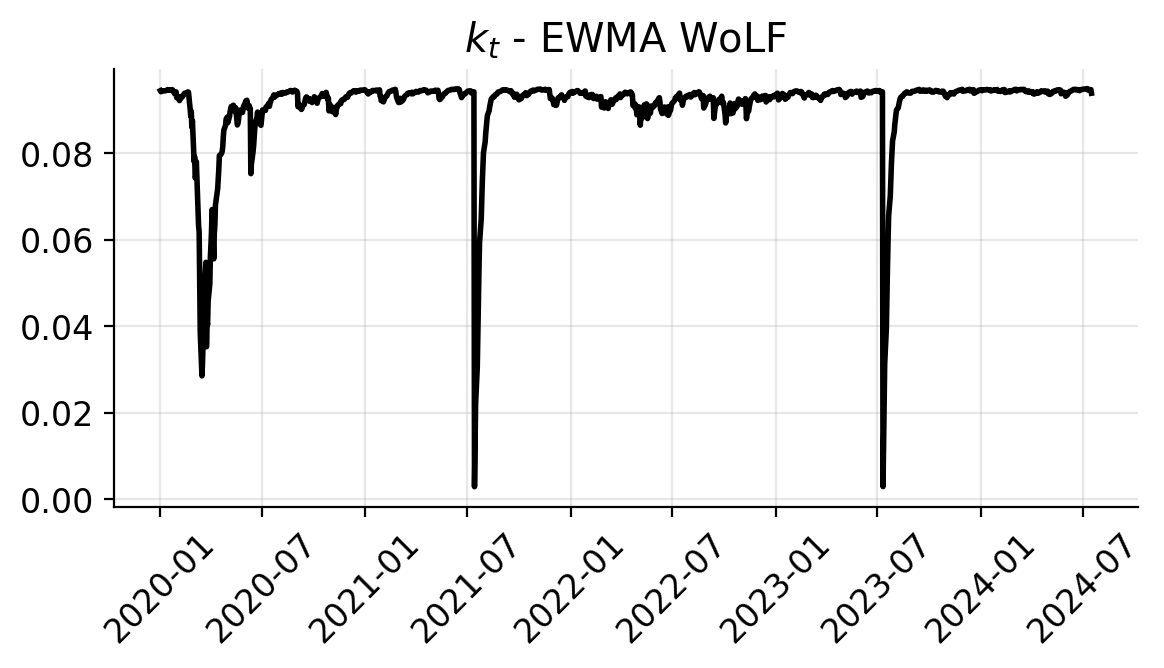

In [257]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.plot(k_hist["2020":], c="black", linewidth=2)
plt.title("$k_t$ - EWMA WoLF")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./wolf-smoothing-factor.svg")

In [181]:
signal = returns.ewm(span=50, adjust=False).mean() - returns.ewm(span=100, adjust=False).mean()
signal = signal / signal.ewm(span=300).std()

In [182]:

m_fast, s_fast = wolf1d(returns.bfill().values, 0, 1, 0.01, 1.25, 0.02)
m_slow, s_slow = wolf1d(returns.bfill().values, 0, 1, 0.01, 5, 0.02)

In [183]:
signal_wolf = m_fast - m_slow
signal_wolf = pd.Series(signal_wolf, index=signal.index)
signal_wolf = signal_wolf / signal_wolf.ewm(span=300).std()

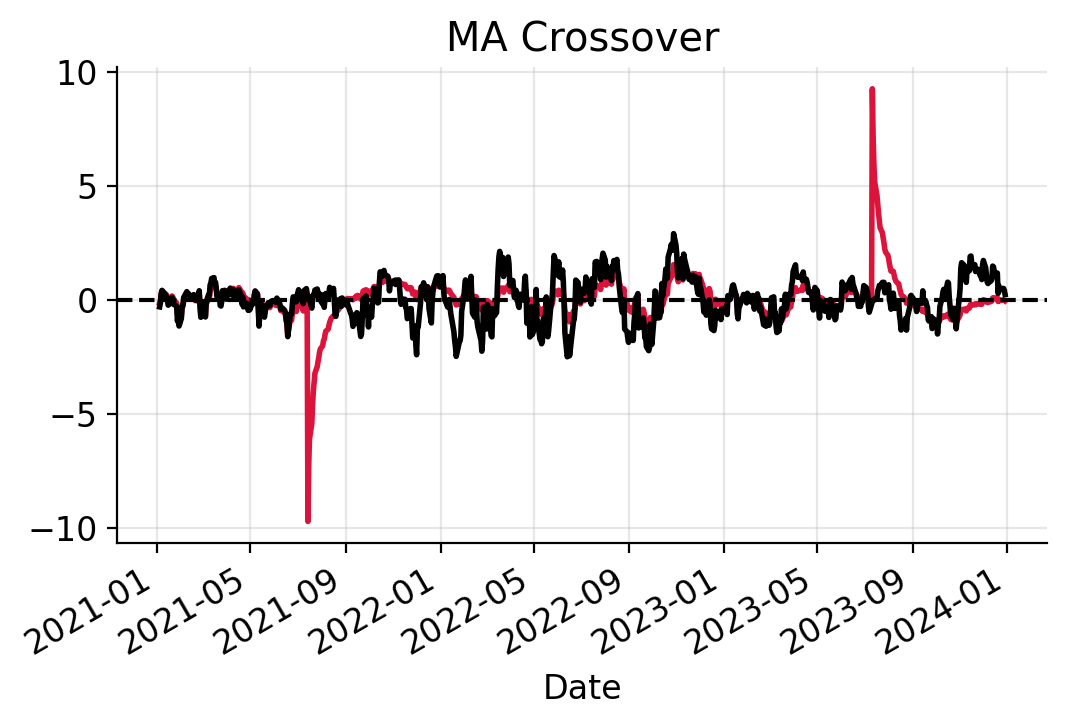

In [214]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.title("MA Crossover")
signal["2021":"2023"].plot(label="EWMA", c="crimson", linewidth=2)
signal_wolf["2021":"2023"].plot(label="WoLF-EWMA", c="black", linewidth=2)
plt.axhline(y=0, c="black", linestyle="--")
plt.grid(alpha=0.3)
plt.savefig("./ewma-crossover.svg")